# Cheat sheet - Option Pricing with Heston Model and Black-Scholes

### by François Goujon

In [51]:
# Imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

## Monte Carlo simulation

### Price evolution under risk-neutral measure (black-scholes):
$$
\frac{dS_t}{S_t} = rdt + \sigma dW_t = rdt + \sqrt{v} dW_t \\
With \ Y_t = \ln(S_t) \ and \ Ito \rightarrow dY_t = \frac{\partial ln}{\partial x}(S_t)dS_t + \frac{1}{2}\frac{\partial^{2} ln}{\partial x^2}(S_t)d \langle S, S \rangle_t = \frac{dS_t}{S_t} - \frac{1}{2S_t^2}d \langle S, S \rangle_t = \frac{dS_t}{S_t} - \frac{v}{2}dt\\
\quad \\
dY_t = (r - \frac{v}{2})dt + \sqrt{v}dW_t \Rightarrow Y_t = Y_0 + (r - \frac{v}{2})t + \sqrt{v}W_t \\
S_t = e^{Y_t} \Rightarrow S_t = S_{0}e^{(r - \frac{\sigma^2}{2})t + \sigma W_t} = S_{0}e^{(r - \frac{v}{2})t + \sqrt{v}W_t} \quad and \ W_t \sim N(0,t)
$$

### Heston model price and variance evolution: <br>
#### Price:
$$
\frac{dS_t}{S_t} = rdt + \zeta\sqrt{v_t}dW_t^s \quad and \ dW_t^s \sim N(0,dt) \ with \ \langle dW^s, dW^v \rangle_t = \rho dt \\
i.e \ dW_t^s = Z^s\sqrt{dt} \ with \ Z^s \sim N(0,1) \ and \ \langle Z^s, Z^v \rangle = \rho \\
\quad \\
\frac{dS_t}{S_t} = rdt + \zeta\sqrt{v_t}Z^{s}\sqrt{dt} \ ; \ with \ Y_t = \ln(S_t) \Rightarrow dY_t = (r - \zeta^{2}\frac{v_t}{2})dt + \zeta\sqrt{v_t}Z^{s}\sqrt{dt} \quad (dY = \frac{dS}{S} - \frac{1}{2S^2} \langle dS, dS \rangle )\\
$$
#### Variance:
$$
dv = \kappa(\theta - v_t)dt + \sigma\sqrt{v_t}dW_t^v \ and \ dW_t^v \sim N(0,dt) \ with \ \langle dW^s, dW^v \rangle_t = \rho dt \\
i.e \ dW_t^v = Z^v\sqrt{dt} \ with \ Z^v \sim N(0,1) \ and \ \langle Z^s, Z^v \rangle = \rho \\
\quad \\
dv = \kappa(\theta - v_t)dt + \sigma\sqrt{v_t}Z^{v}\sqrt{dt}\\
$$
#### Discretize:
$$
Y_i = Y_{i-1} + (r - \zeta^{2}\frac{V_{i-1}}{2})dt + \zeta\sqrt{V_{i-1}}Z_{i-1}^{s}\sqrt{dt} \\
\Rightarrow S_i = S_{i-1}.\exp((r - \zeta^{2}\frac{V_{i-1}}{2})dt + \zeta\sqrt{V_{i-1}}Z_{i-1}^{s}\sqrt{dt}) \\
\quad \\
V_i = V_{i-1} + \kappa(\theta - V_{i-1})dt + \sigma\sqrt{V_{i-1}}Z_{i-1}^{v}\sqrt{dt} \quad \ if > 0 \ \ else \ 0 \\
$$

## Functions

In [60]:
def heston_model(s0, v0, r, rho, kappa, theta, sigma, zeta, t, n, m):
    """
    Computes Heston model simulations for the chosen parameters
    
    Inputs:
    - s0, v0: initial parameters for asset and variance
    - r: risk free rate
    - rho: correlation between asset returns and variance
    - kappa: rate of mean reversion in variance process
    - theta: long-term mean of variance process
    - sigma: vol of vol / volatility of variance process
    - zeta: volatility influence coefficient in price
    - t: time of simulation in years
    - n: number of time steps
    - m: number of simulations
    
    Outputs:
    - Asset prices over time (numpy array)
    - Variance over time (numpy array)
    """
    # Initialisation
    dt = t/n
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])
    s = np.full(shape=(n+1, m), fill_value=s0)
    v = np.full(shape=(n+1, m), fill_value=v0)
    # Sampling correlated brownian motions under risk-neutral measure
    z = np.random.multivariate_normal(mu, cov, (n,m))
    
    for i in range(1, n+1):
        s[i] = s[i-1] * np.exp((r - 0.5*(zeta**2)*v[i-1])*dt + zeta*np.sqrt(v[i-1] * dt)*z[i-1,:,0])
        v[i] = np.maximum(v[i-1] + kappa*(theta - v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*z[i-1,:,1], 0)
        
    return s, v
    
def plot_price_var(s, v, t, n):
    """
    Plot of price and variance evolution of the asset following Heston simulation
    
    Inputs:
    - s, v: Time array of asset price/variance evolution
    - t: Time to maturity 
    - n: Number of time steps
    """
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(26, 6))
    time = np.linspace(0, t, n+1)
    ax1.plot(time, s)
    ax1.set_title("Simulations of asset price evolution")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Asset Price")
    
    ax2.plot(time, v)
    ax2.set_title("Simulations of asset variance evolution")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Asset Variance")
    
    plt.show()
    
def plot_value_distrib(s0, r, ss, rhos, theta, t, m):
    """
    Plot of value distribution at maturity
    
    Inputs:
    - s0: initial price of asset
    - r: risk free rate
    - ss: List of results of simulations of asset price evolution 
    - rhos: List of correlations between asset returns and variance used for simulations
    - theta: long-term mean of variance process
    - t: Time to maturity
    - m: number of simulations
    """
    #geo_brownian_motion = s0*np.exp((r - 0.5*theta)*t + np.sqrt(theta)*np.sqrt(t)*np.random.normal(0,1,M))
    geo_brownian_motion = s0*np.exp((r - 0.5*theta)*t + np.sqrt(theta)*np.random.normal(0,t,m))
    
    fig, ax = plt.subplots(figsize=(10,5))
    for s, rho in zip(ss, rhos):
        ax = sns.kdeplot(s[-1], label=fr"$\rho= {rho}$", ax=ax)
    ax = sns.kdeplot(geo_brownian_motion, label="GBM", ax=ax)
    ax.set_title("Asset Price Density under Heston Model")
    ax.set_xlim([0.2*s0,2*s0])
    ax.set_xlabel("S")
    ax.set_ylabel("Density")
    plt.legend()
    plt.show()

def plot_option_price_ame(s0, ss, r, t):
    """
    Plot american options premiums depending on strike. 
    The mean of s-k (resp k-s) is taken for all dates between day 1 and day T.
    Not sure this makes much sens

    Inputs:
    - s0: initial asset price
    - ss: List of results of simulations of asset price evolution 
    - r: risk free rate
    - T: time to maturity
    Outputs:
    - ks: List of strikes
    - puts_list, calls_list: List of values of options at maturity i.e their price
    """
    # Set strikes and complete MC option price for different strikes
    ks = np.arange(0.2*s0, 2*s0, 0.01*s0)

    puts_list = []
    calls_list = []
    
    for s in ss:
        puts = np.array([np.exp(-r*t)*np.mean(np.maximum(k-s, 0)) for k in ks])
        calls = np.array([np.exp(-r*t)*np.mean(np.maximum(s-k, 0)) for k in ks])
        puts_list.append(puts)
        calls_list.append(calls)
    print("Value expectetion done.")

    ns = len(ss)
    rows = int(np.ceil(ns/3))

    fig, axs= plt.subplots(rows,3, figsize=(26, 6*rows))
    for i, ax in enumerate(axs.flatten()[:ns]):
        ax.plot(ks, calls_list[i], label="Call premiums")
        ax.plot(ks, puts_list[i], label="Put premiums")
        ax.set_ylabel("Premium")
        ax.set_xlabel("Strike")
        ax.set_title(f"Option premium {i+1} under Heston Model")
        ax.legend()
    plt.show()

    return ks, calls_list, puts_list

def plot_option_price_eur(s0, ss, r, t):
    """
    Plot european options premiums depending on strike.
    The mean of s-k (resp k-s) is taken for the last date.

    Inputs:
    - s0: initial asset price
    - ss: List of results of simulations of asset price evolution 
    - r: risk free rate
    - T: time to maturity
    Outputs:
    - ks: List of strikes
    - puts_list, calls_list: List of values of options at maturity i.e their price
    """
    # Set strikes and complete MC option price for different strikes
    ks = np.arange(0.2*s0, 2*s0, 0.01*s0)

    puts_list = []
    calls_list = []
    
    for s in ss:
        puts = np.array([np.exp(-r*t)*np.mean(np.maximum(k-s[-1], 0)) for k in ks])
        calls = np.array([np.exp(-r*t)*np.mean(np.maximum(s[-1]-k, 0)) for k in ks])
        puts_list.append(puts)
        calls_list.append(calls)
    print("Value expectetion done.")

    ns = len(ss)
    rows = int(np.ceil(ns/3))

    fig, axs= plt.subplots(rows,3, figsize=(26, 6*rows))
    for i, ax in enumerate(axs.flatten()[:ns]):
        ax.plot(ks, calls_list[i], label="Call premiums")
        ax.plot(ks, puts_list[i], label="Put premiums")
        ax.set_ylabel("Premium")
        ax.set_xlabel("Strike")
        ax.set_title(f"Option premium {i+1} under Heston Model")
        ax.legend()
    plt.show()

    return ks, calls_list, puts_list

    
def plot_vol_smile(s0, ks, calls_list, puts_list, r, t):
    """
    Plot volatility (=std) depending on strike
    
    Inputs:
    - s0: initial asset price
    - ss: List of results of simulations of asset price evolution 
    - r: risk free rate
    - T: time to maturity
    """
    puts_impvol_list = []
    calls_impvol_list = []
    
    for ca, pu in zip(calls_list, puts_list):
        put_impvol = implied_vol(pu, s0, ks, t, r, flag="p", q=0, return_as='numpy', on_error='ignore')
        call_impvol = implied_vol(ca, s0, ks, t, r, flag="c", q=0, return_as='numpy', on_error='ignore')
        puts_impvol_list.append(put_impvol)
        calls_impvol_list.append(call_impvol)
    print("Implied volatility (std) calculation done.")
    
    ns = len(calls_list)
    rows = int(np.ceil(ns/3))

    fig, axs= plt.subplots(rows,3, figsize=(26, 6*rows))
    for i, ax in enumerate(axs.flatten()[:ns]):
        ax.plot(ks, calls_impvol_list[i], label="Implied Vol Calls")
        ax.plot(ks, puts_impvol_list[i], label="Implied Vol Puts")
        ax.set_ylabel("Implied volatility (std)")
        ax.set_xlabel("Strike")
        ax.set_title(f"Implied volatility (std) {i+1} under Heston Model")
        ax.legend()
    plt.show()

def bs_model_mc(s0, r, theta, t, m):
    s = s0*np.exp((r - 0.5*theta)*t + np.sqrt(theta)*np.random.normal(0,t,m))
    return s

def implied_vol_mc(s0, r, k, t, m):
    """
    Plot the option premium depending on volatility for the chosen parameters

    Inputs:
    - s0: initial asset price
    - r: risk free rate
    - k: strike price
    - t: time of simulation in years
    - m: number of simulations in MC
    
    Outputs:
    - thetas: volatilities
    - calls, puts: option premium for the different theta values
    """
    stds = np.arange(0, 0.7, 0.001)
    thetas = stds**2
    ss = []
    for theta in thetas:
        s = s0*np.exp((r - 0.5*theta)*t + np.sqrt(theta)*np.random.normal(0,t,m))
        ss.append(s)

    puts = []
    calls = []
    for s in ss:
        put = np.exp(-r*t)*np.mean(np.maximum(k-s, 0))
        call = np.exp(-r*t)*np.mean(np.maximum(s-k, 0))
        puts.append(put)
        calls.append(call)

    fig, axs = plt.subplots(2, 2, figsize=(24,10))
    axs[0,0].plot(stds, calls, label="Calls")
    axs[0,0].set_title("Implied volatility (std) Calls")
    axs[1,0].plot(stds[:350], calls[:350], label="Calls")
    axs[0,1].plot(stds, puts, label="Puts")
    axs[0,1].set_title("Implied volatility (std) Puts")
    axs[1,1].plot(stds[:350], puts[:350], label="Puts")
    for ax in axs.flatten():
        ax.set_xlabel("Volatility (std)")
        ax.set_ylabel("Option premium")
        ax.legend()
    plt.show()
    
    return thetas, calls, puts


def plot_bs_mc(s0, s, r, t):
    """
    Plot volatility depending on strike
    
    Inputs:
    - s0: initial asset price
    - s: asset price evolution
    - r: risk free rate
    - T: time to maturity
    """
    # Set strikes and complete MC option price for different strikes
    ks = np.arange(0.2*s0, 2*s0, 0.01*s0)

    puts = np.array([np.exp(-r*t)*np.mean(np.maximum(k-s, 0)) for k in ks]) # Mean of difference only at maturity
    calls = np.array([np.exp(-r*t)*np.mean(np.maximum(s-k, 0)) for k in ks])
    
    put_impvol = implied_vol(puts, s0, ks, t, r, flag="p", q=0, return_as='numpy', on_error='ignore')
    call_impvol = implied_vol(calls, s0, ks, t, r, flag="c", q=0, return_as='numpy', on_error='ignore')
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(26, 6))
    ax1.plot(ks, calls, label="Call premiums")
    ax1.plot(ks, puts, label="Put premiums")
    ax1.set_ylabel("Premium")
    ax1.set_xlabel("Strike")
    ax1.set_title("Option premium under BS Model")
    ax1.legend()
    ax2.plot(ks, call_impvol, label="Implied Vol Calls")
    ax2.plot(ks, put_impvol, label="Implied Vol Puts")
    ax2.set_ylabel("Implied vol")
    ax2.set_xlabel("Strike")
    ax2.set_title("Implied vol under Heston Model")
    ax2.legend()
    plt.show()

## Results

### Parameters

In [57]:
# Heston paramaters

s0 = 100.0  # Asset price
v0 = 0.25**2   # initial variance under risk-neutral dynamics
r = 0.01   # Risk free rate
rho = 0.7      # correlation between returns and variances under risk-neutral dynamics
kappa = 3  # Rate of mean reversion of variance under risk-neutral dynamics
theta = 0.2**2 # long-term mean of variance under risk-neutral dynamics
sigma = 0.6    # volatility of volatility
zeta = 1 # volatility influence coefficient in price

# Simualtion parameters

T = 1.0    # Time to maturity in years
N = 252    # Number of time steps in simulation
M = 100000   # Number of simulations

In [4]:
print(v0) # Initial variance
print(theta) # Long term mean of variance

0.0625
0.04000000000000001


### Computations

In [5]:
# Black-Scholes model
s_bs = bs_model_mc(s0, r, theta, T, M)

In [6]:
# Heston model classic (with zeta = 1)
s1, v1 = heston_model(s0, v0, r, rho, kappa, theta, sigma, zeta, T, N, M)
s2, v2 = heston_model(s0, v0, r, -rho, kappa, theta, sigma, zeta, T, N, M)
s3, v3 = heston_model(s0, v0, r, 0, kappa, theta, sigma, zeta, T, N, M)

In [7]:
# Heston model with zeta = 0.7
ss1, vv1 = heston_model(s0, v0, r, rho, kappa, theta, sigma, 0.7, T, N, M)
ss2, vv2 = heston_model(s0, v0, r, -rho, kappa, theta, sigma, 0.7, T, N, M)
ss3, vv3 = heston_model(s0, v0, r, 0, kappa, theta, sigma, 0.7, T, N, M)

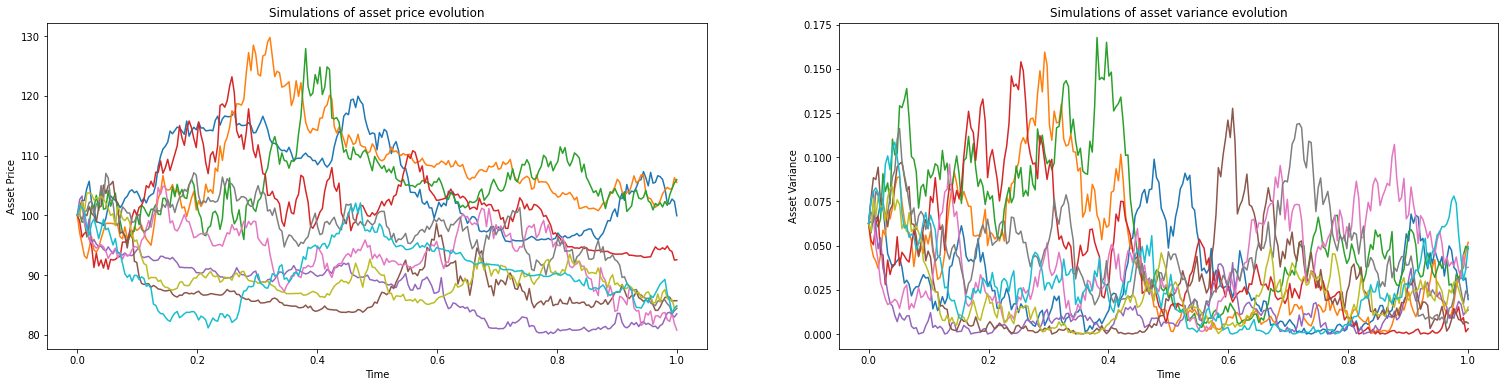

In [8]:
# Plot classic Heston model asset price evolution
plot_price_var(s1[:, :10], v1[:, :10], T, N)

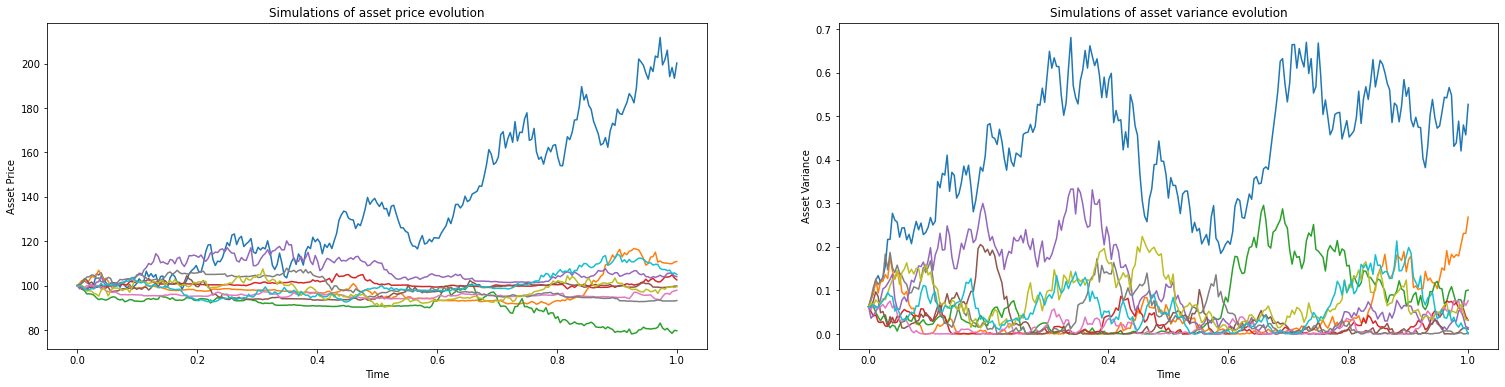

In [9]:
# Plot Heston model 2 asset price evolution
plot_price_var(ss1[:, :10], vv1[:, :10], T, N)

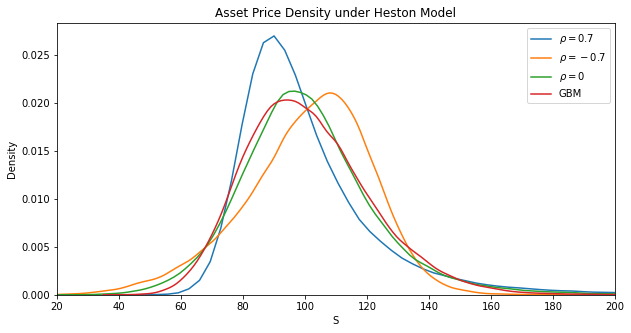

In [10]:
# Plot Heston model 1 asset price distribution at maturity
plot_value_distrib(s0, r, [s1, s2, s3], [rho, -rho, 0], theta, T, M)

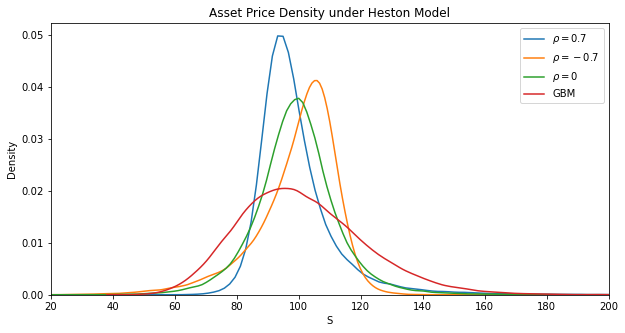

In [11]:
# Plot Heston model 2 asset price distribution at maturity
plot_value_distrib(s0, r, [ss1, ss2, ss3], [rho, -rho, 0], theta, T, M)

Value expectetion done.


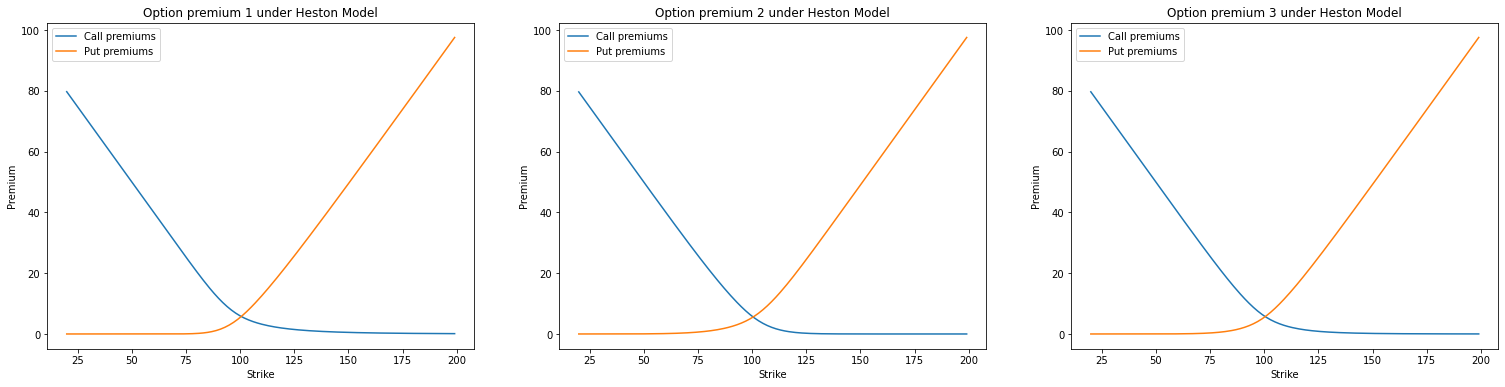

In [12]:
# Plot Heston model 1 american option premiums depending on strike with MC
ks_ame, calls_list_ame, puts_list_ame = plot_option_price_ame(s0, [s1, s2, s3], r, T)

Value expectetion done.


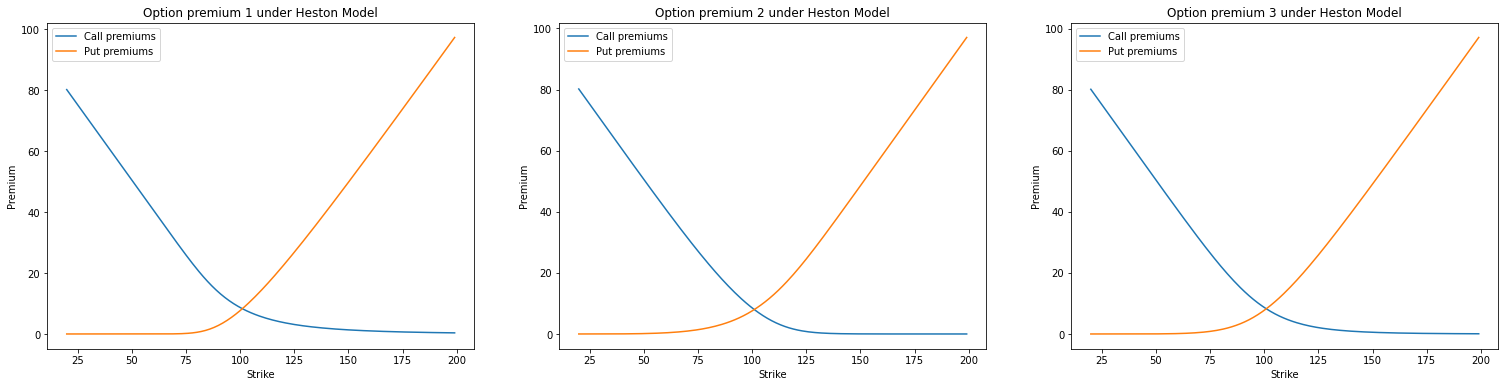

In [13]:
# Plot Heston model 1 european option premiums depending on strike with MC
ks_eur, calls_list_eur, puts_list_eur = plot_option_price_eur(s0, [s1, s2, s3], r, T)

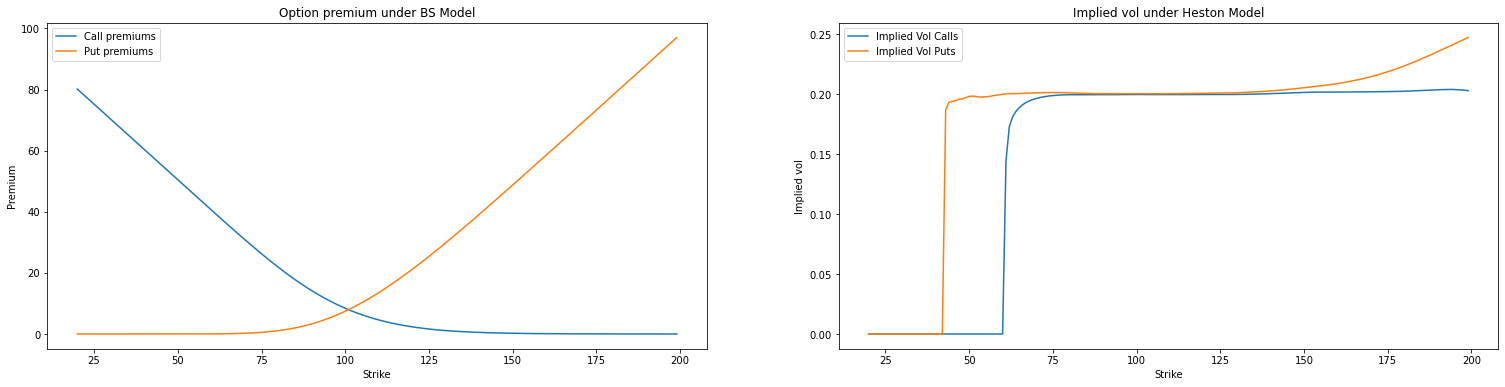

In [14]:
# Plot of black-scholes option premium computed via MC and implied volatility
# Volatility is flat as expected (expect edges cases)
plot_bs_mc(s0, [s_bs], r, T)

Implied volatility (std) calculation done.


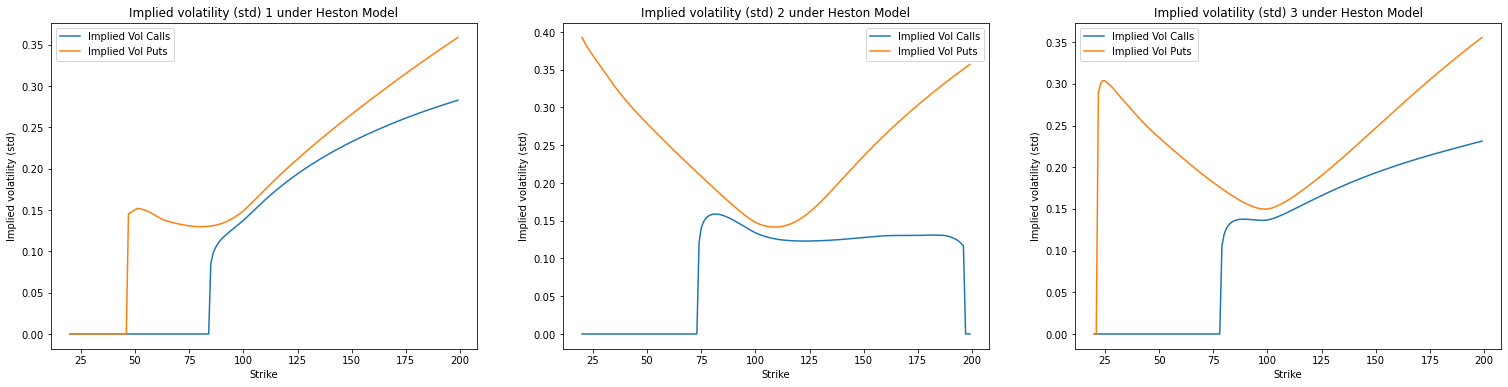

In [52]:
# Implied volatility for american options
plot_vol_smile(s0, ks_ame, calls_list_ame, puts_list_ame, r, T)

Implied volatility calculation done.


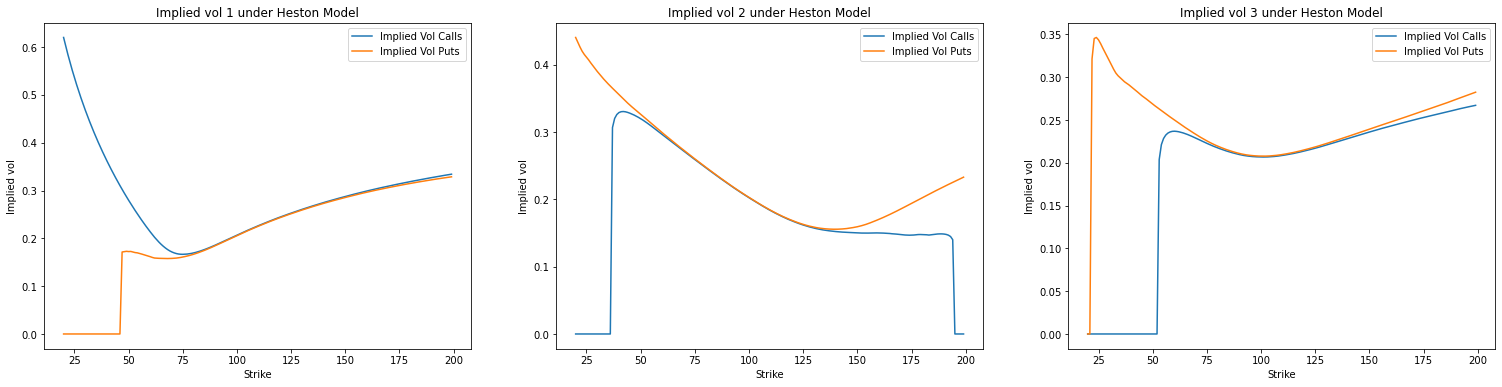

In [16]:
# Implied volatility for european options
plot_vol_smile(s0, ks_eur, calls_list_eur, puts_list_eur, r, T)

The implied volatility for a strike 50 on the first chart is around 0.3

In [33]:
# european option with strike 50 (30 because we start at 20 with step 1) is worth 50.53
calls_list_eur[0][30]

50.534908908057325

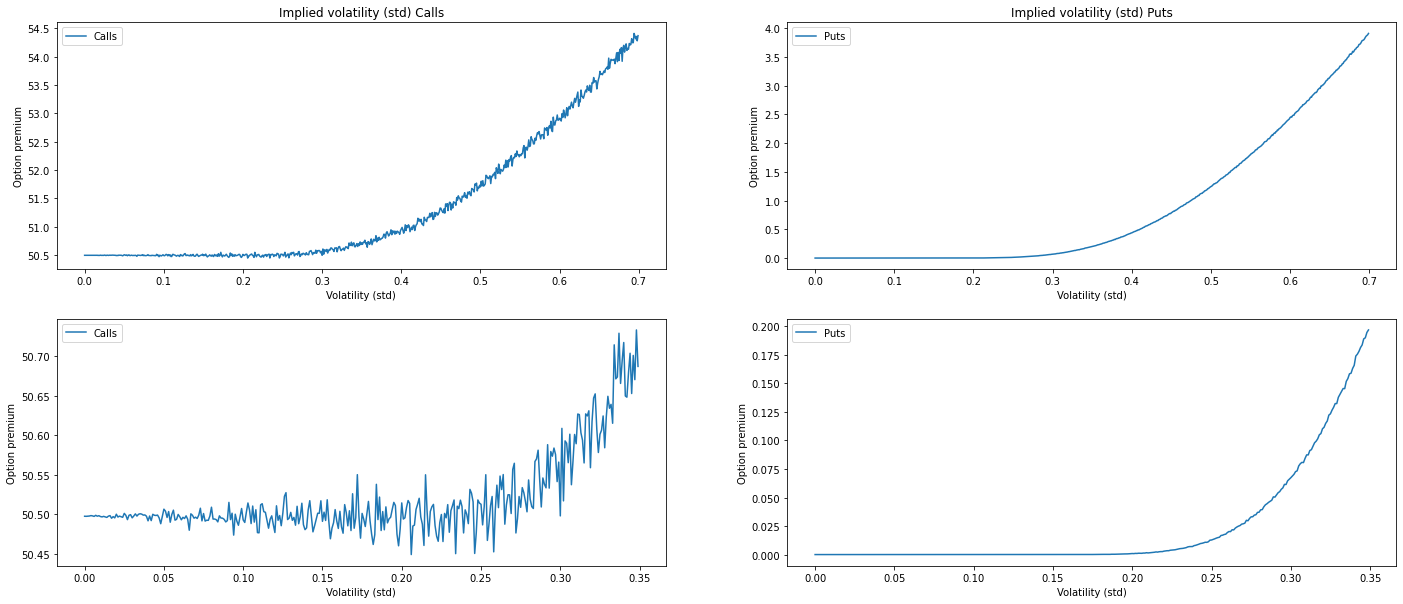

In [50]:
# The implied volatility corresponding to 50.53 is around 0.3 which is what we observe above
thsl, casl, pusl = implied_vol_mc(s0, r, 50, T, M*10)

Model with zeta = 0.7

Value expectetion done.


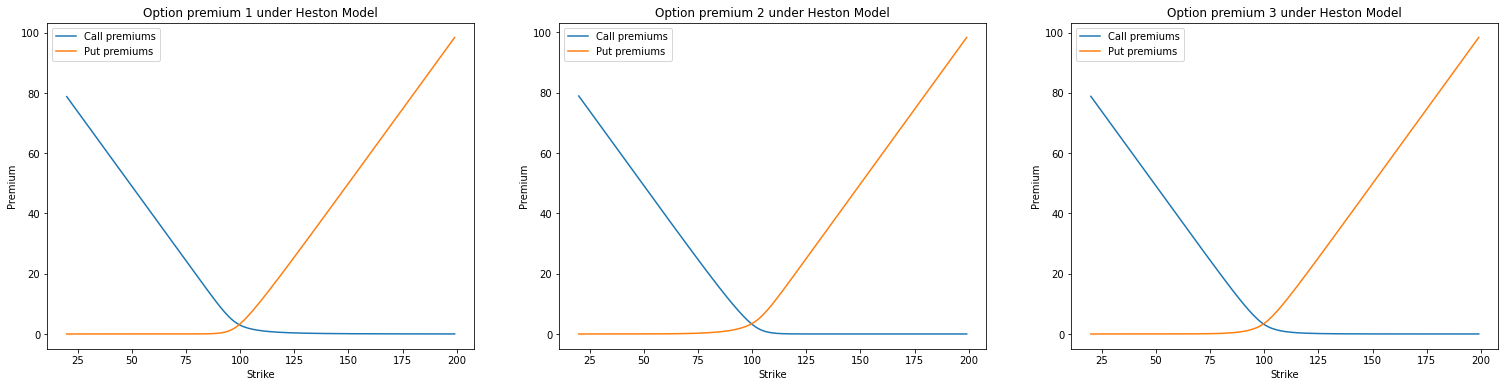

In [18]:
ks_ame2, calls_list_ame2, puts_list_ame2 = plot_option_price_ame(s0, [ss1, ss2, ss3], r, T)

Value expectetion done.


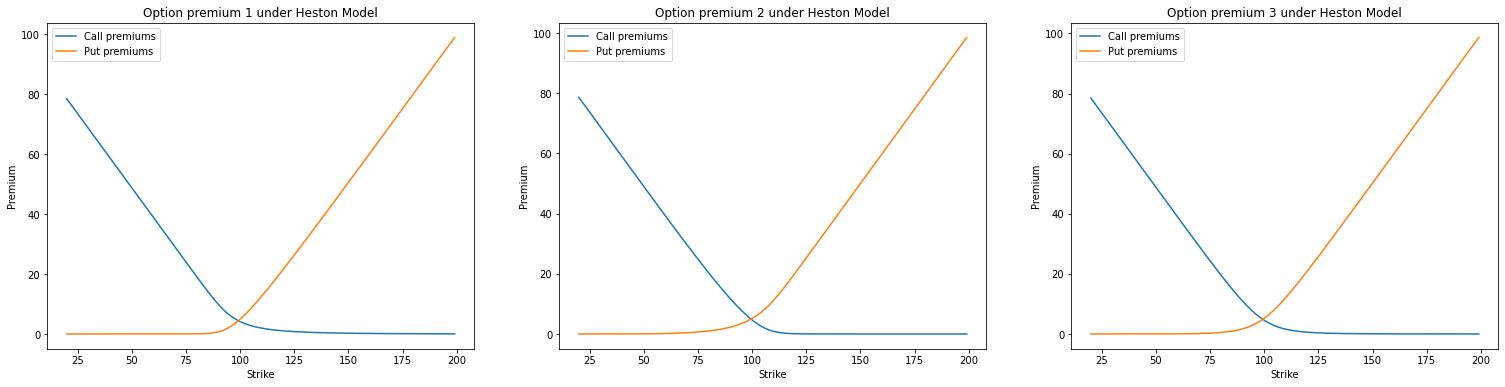

In [19]:
ks_eur2, calls_list_eur2, puts_list_eur2 = plot_option_price_eur(s0, [ss1, ss2, ss3], r, T)

Implied volatility calculation done.


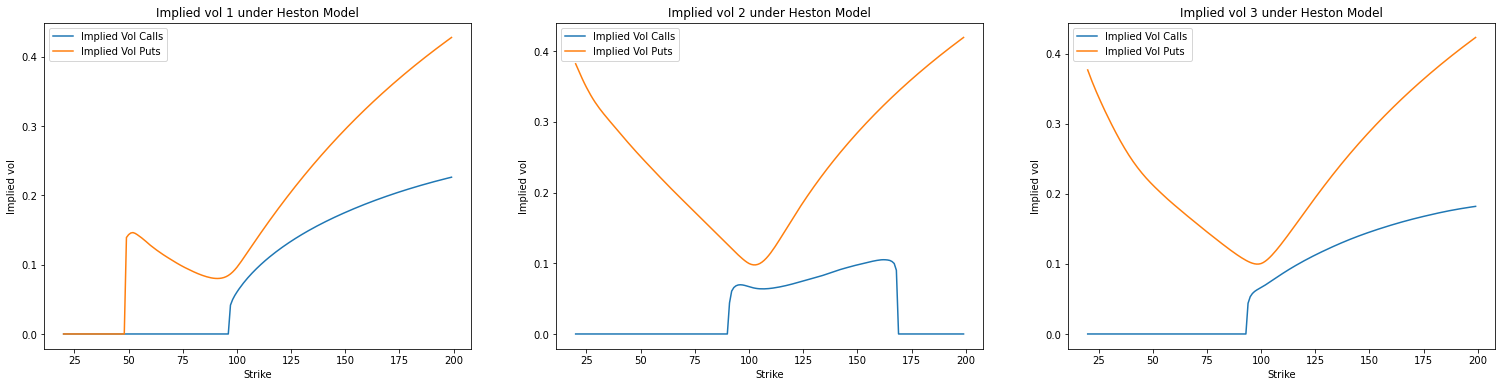

In [20]:
plot_vol_smile(s0, ks_ame2, calls_list_ame2, puts_list_ame2, r, T)

Implied volatility calculation done.


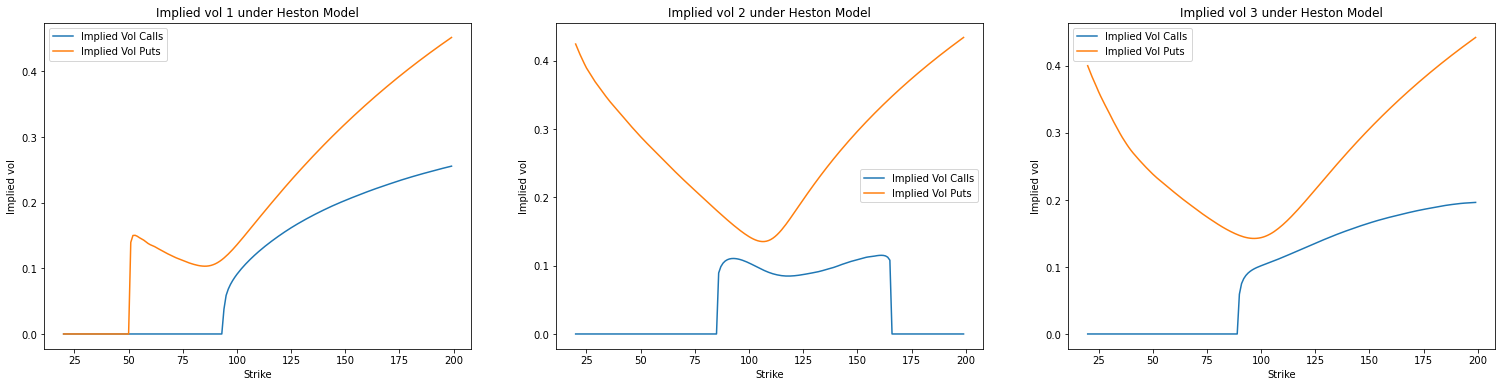

In [21]:
plot_vol_smile(s0, ks_eur2, calls_list_eur2, puts_list_eur2, r, T)